# **Connect to Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/My\ Drive/Colab\ Notebooks/

/content/gdrive/My Drive/Colab Notebooks


# **Load dataset**

- Load data from Google Drive, which is created on local laptop.
- In Google Drive, have 3 directories: train_data - valid_data - test_data.
- In each folder, data is stored in h5py format.

In [3]:
import numpy as np
import h5py

### **Load training set**

In [4]:
def load_train_dataset():
    X_train = []
    y_train = []

    filename_prefix = 'train_data/X_train_'

    for i in range(1, 11):
        
        filename = filename_prefix + str(i) + '.hdf5'
        print('Loading batch ' + str(i) + ' ...')

        with h5py.File(filename, 'r') as f:
            for j in f['X'][:]:
                X_train.append(j)

            for j in f['y'][:]:
                y_train.append(j)

    return X_train, y_train

In [5]:
X_train, y_train = load_train_dataset()

Loading batch 1 ...
Loading batch 2 ...
Loading batch 3 ...
Loading batch 4 ...
Loading batch 5 ...
Loading batch 6 ...
Loading batch 7 ...
Loading batch 8 ...
Loading batch 9 ...
Loading batch 10 ...


In [6]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [7]:
print(X_train.shape)
print(y_train.shape)

(194266, 3, 50, 50)
(194266,)


### **Load valid set**

In [8]:
def load_valid_dataset():
    X_valid = []
    y_valid = []

    filename_prefix = 'valid_data/X_valid_'

    for i in range(1, 4):

        
        filename = filename_prefix + str(i) + '.hdf5'
        print('Loading batch ' + str(i) + ' ...')

        with h5py.File(filename, 'r') as f:
            for j in f['X'][:]:
                X_valid.append(j)

            for j in f['y'][:]:
                y_valid.append(j)

    return X_valid, y_valid

In [9]:
X_valid, y_valid = load_valid_dataset()

Loading batch 1 ...
Loading batch 2 ...
Loading batch 3 ...


In [10]:
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

In [11]:
print(X_valid.shape)
print(y_valid.shape)

(41629, 3, 50, 50)
(41629,)


### **Load test set**

In [12]:
def load_test_dataset():
    X_test = []
    y_test = []

    filename_prefix = 'test_data/X_test_'

    for i in range(1, 4):

        
        filename = filename_prefix + str(i) + '.hdf5'
        print('Loading batch ' + str(i) + ' ...')

        with h5py.File(filename, 'r') as f:
            for j in f['X'][:]:
                X_test.append(j)

            for j in f['y'][:]:
                y_test.append(j)

    return X_test, y_test

In [13]:
X_test, y_test = load_test_dataset()

Loading batch 1 ...
Loading batch 2 ...
Loading batch 3 ...


In [14]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [15]:
print(X_test.shape)
print(y_test.shape)

(41629, 3, 50, 50)
(41629,)


# **Building Model Multilayer Perceptron**

In [16]:
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, recall_score, f1_score
import torch
import torch.nn as nn
from torch import optim

### **Parameters of the model**

In [17]:
EPOCHS = 20
BATCH_SIZE = 32
LR = 1e-6
INPUT_SIZE = 50 * 50 * 3
OUTPUT_SIZE = 2

### **Defining the Model**

The model will be a neural network, specifically a multilayer perceptron (MLP) with 3 hidden layers.

**Model description:**

- Input model is RGB image data (3 color channels, 50 pixels height, 50 pixels width)
- We will flatten image data in to 7500 (3 - 50 - 50) features.
- Next, the 7500 features will pass through the first hidden layer to tranform into 1024 dimensions.
- Then continue pass through the second hidden layer to tranform into 128 dimensions.
- Then continue pass through the third hidden layer to tranform into 16 dimensions.
- Finally, an output layer which will transform into 2 dimensions vector, corresponds to the 2 labels: "negative" and "positive".

**Activation function**

- The ReLU is the most used activation function in the world right now. Since, it is used in almost all the convolutional neural networks or deep learning. 
- Computationally efficient—allows the network to converge very quickly.
- Non-linear—although it looks like a linear function, ReLU has a derivative function and allows for backpropagation.

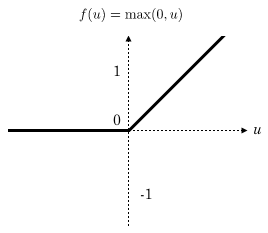


**Avoid overfitting**

To avoid overfitting in neural networks, use two methods of Dropout and Batch normalization.
- **Dropout**: is one of the most commonly used and the most powerful regularization techniques used in deep learning. Dropout is applied to intermediate layers of the model during the training time. Let's look at an example of how dropout is applied on a linear layer's output that generates 10 values:

  + The figure shows what happens when dropout is applied to the linear layer output with a threshold value of 0.2. It randomly masks or zeros 20% of data, so that the model will not be dependent on a particular set of weights or patterns, thus overfitting.

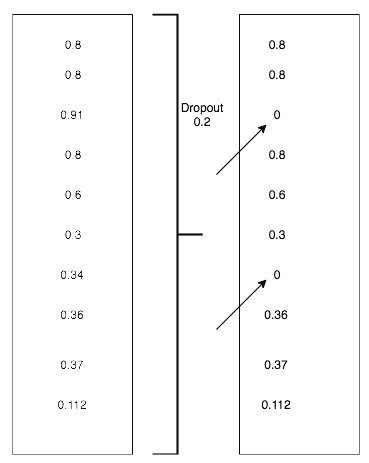

- **Batch normalization**: (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling. To increase the stability of a neural network, batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.


In [18]:
class MLP(nn.Module):
  
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        hidden_size_1 = 1024
        hidden_size_2 = 128
        hidden_size_3 = 16

        self.hidden_1 = nn.Linear(input_size, hidden_size_1)
        self.hidden_2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.hidden_3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.out = nn.Linear(hidden_size_3, output_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.2)
        self.batch_norm_3 = nn.BatchNorm1d(hidden_size_3)

    def forward(self, batch):
        batch_size = batch.shape[0]
        batch = batch.view(batch_size, -1)
        hidden_1 = self.relu(self.hidden_1(batch))
        hidden_2 = self.relu(self.hidden_2(hidden_1))
        hidden_3 = self.relu(self.hidden_3(hidden_2))
        hidden_3 = self.batch_norm_3(hidden_3)
        hidden_3 = self.dropout(hidden_3)
        out = self.out(hidden_3)

        return out

In [19]:
model = MLP(INPUT_SIZE, OUTPUT_SIZE)
print(model)

MLP(
  (hidden_1): Linear(in_features=7500, out_features=1024, bias=True)
  (hidden_2): Linear(in_features=1024, out_features=128, bias=True)
  (hidden_3): Linear(in_features=128, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batch_norm_3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


**Calculate the number of trainable parameters (weights and biases)**

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,814,354 trainable parameters


**Optimization Algorithm**

- **Adam** (Adaptive Moment Estimation) works with momentums of first and second order. The intuition behind the Adam is that we don’t want to roll so fast just because we can jump over the minimum, we want to decrease the velocity a little bit for a careful search.

- Advantages:
  + The method is too fast and converges rapidly.
  + Rectifies vanishing learning rate, high variance.

- Disadvantages:
  + Computationally costly.

In [22]:
optimizer = optim.Adam(model.parameters(), lr=LR)

**Loss Function**

- **Cross-entropy** can be used to define a loss function in machine learning and optimization.

In [23]:
loss_fn = nn.CrossEntropyLoss()

**Calculate the accuracy**
- This takes the index of the highest value for your prediction and compares it against the actual class label. Then divide how many our model got correct by the amount in the batch to calculate accuracy across the batch.

In [24]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

**Create mini-batch**

In [25]:
def next_batch(X, y, batch_size):
    # Mini-batch
    for i in np.arange(0, X.shape[0], batch_size):
        yield X[i:i + batch_size], y[i:i + batch_size]

**Transform the model and data to GPU**

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
model = model.to(device)
loss_fn = loss_fn.to(device)

### **Training the Model**

**Define Traning step**
- Put the model into train mode: **model.train()**
- Iterate over batches of data.
- Transform the batch to GPU mode.
- Clear the gradients calculated from the last batch.
- Impliment model for batch of images: x, get predictions, y_pred.
- Calculate the loss between prediction labels and the actual labels.
- Calculate the accuracy between prediction labels and the actual labels.
- Calculate the gradients of each parameter.
- Update the parameters by taking optimizer step.
- Return the loss and the accuracy of epoch.

In [28]:
def train(model, X, y, optimizer, loss_fn, device, batch_size):
    epoch_loss = 0
    epoch_acc = 0
    
    # Impliment train mode
    model.train()
    
    for (batchX, batchY) in next_batch(X, y, batch_size):
        x = torch.from_numpy(batchX).to(device)
        y = torch.from_numpy(batchY).to(device)
        
        # Clear the gradients calculated from the last batch
        optimizer.zero_grad()
                
        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        
        # Calculate the gradients of each parameter
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    num_of_batchs = math.ceil(len(X) / batch_size)
    return epoch_loss / num_of_batchs, epoch_acc / num_of_batchs

**Define Evaluation step**

- Similar the training step. The differences are:
  + Put the model into evalution mode: **model.eval()**
  + Don't calculate the gradients of each parameter.
  + Don't update the parameters by taking optimizer step.

- **torch.no_grad()** ensures that gradients are not calculated for whatever is inside the with block. As our model will not have to calculate gradients it will be faster and use less memory.

In [29]:
def evaluate(model, X, y, loss_fn, device, batch_size):
    epoch_loss = 0
    epoch_acc = 0
    
    # Impliment evaluation mode
    model.eval()
    
    with torch.no_grad():
        for (batchX, batchY) in next_batch(X, y, batch_size):
            x = torch.from_numpy(batchX).to(device)
            y = torch.from_numpy(batchY).to(device)

            y_pred = model(x)

            loss = loss_fn(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    num_of_batchs = math.ceil(len(X) / batch_size)
    return epoch_loss / num_of_batchs, epoch_acc / num_of_batchs

**Calculate the time need to run each epoch**

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

**Training the Model**
- Iterate over epochs.
- In each epochs:
  - Training the Model with training set.
  - Evaluate the Model with validation set.
  - Check the best validation loss and save the model parameters
  - Print the result metrics: Loss and Accuracy.

In [31]:
best_valid_loss = float('inf')
train_loss_list = list()
valid_loss_list = list()

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, X_train, y_train, optimizer, loss_fn, device, batch_size=BATCH_SIZE)
    valid_loss, valid_acc = evaluate(model, X_valid, y_valid, loss_fn, device, batch_size=BATCH_SIZE)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'mlp_model.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 0.535 | Train Acc: 80.42%
	 Val. Loss: 0.524 |  Val. Acc: 81.32%
Epoch: 02 | Epoch Time: 0m 21s
	Train Loss: 0.514 | Train Acc: 81.65%
	 Val. Loss: 0.510 |  Val. Acc: 81.32%
Epoch: 03 | Epoch Time: 0m 21s
	Train Loss: 0.501 | Train Acc: 81.84%
	 Val. Loss: 0.548 |  Val. Acc: 77.03%
Epoch: 04 | Epoch Time: 0m 21s
	Train Loss: 0.489 | Train Acc: 82.15%
	 Val. Loss: 0.513 |  Val. Acc: 79.54%
Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 0.479 | Train Acc: 82.37%
	 Val. Loss: 0.470 |  Val. Acc: 81.96%
Epoch: 06 | Epoch Time: 0m 21s
	Train Loss: 0.488 | Train Acc: 82.84%
	 Val. Loss: 0.511 |  Val. Acc: 81.63%
Epoch: 07 | Epoch Time: 0m 21s
	Train Loss: 0.485 | Train Acc: 83.08%
	 Val. Loss: 0.525 |  Val. Acc: 78.99%
Epoch: 08 | Epoch Time: 0m 21s
	Train Loss: 0.474 | Train Acc: 83.28%
	 Val. Loss: 0.501 |  Val. Acc: 80.86%
Epoch: 09 | Epoch Time: 0m 21s
	Train Loss: 0.464 | Train Acc: 83.29%
	 Val. Loss: 0.463 |  Val. Acc: 83.06%
Epoch: 10 | Epoch T

**Load the parameters of the best model and evaluate the model on the test set**

In [32]:
model.load_state_dict(torch.load('mlp_model.pt'))

test_loss, test_acc = evaluate(model, X_test, y_test, loss_fn, device, batch_size=BATCH_SIZE)

**Test Loss**

In [33]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.389 | Test Acc: 84.25%


### **Examining the Model**

**Visualizing loss of train set and valid set**

In [34]:
epoch_list = np.arange(1, 21)

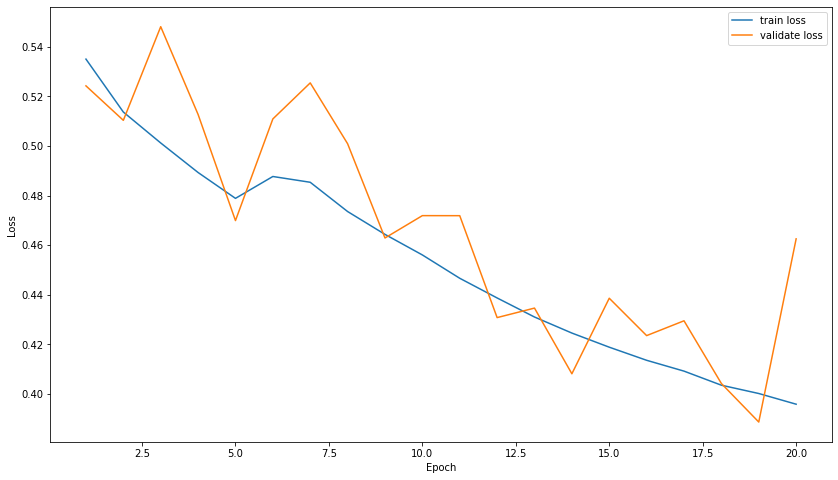

In [35]:
fig, ax = plt.subplots(figsize=(14,8))

ax.plot(epoch_list, train_loss_list, label='train loss')
ax.plot(epoch_list, valid_loss_list, label='validate loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.legend()
plt.show()

**Get the predictions of all dataset**

In [36]:
def get_predictions(model, X, y, device, batch_size):
    
    model.eval()
    predict_label = []

    with torch.no_grad():
        for (batchX, batchY) in next_batch(X, y, batch_size):
            x = torch.from_numpy(batchX).to(device)

            y_pred = model(x)
            top_pred = y_pred.argmax(1, keepdim = True)

            for i in top_pred:
                predict_label.append(i.item())

    return np.array(predict_label)

In [37]:
predict_label = get_predictions(model, X_test, y_test, device, batch_size=BATCH_SIZE)

**Confusion matrix**

In [38]:
cm = confusion_matrix(y_test, predict_label)
print(cm)

[[27505  2210]
 [ 4347  7567]]


In [39]:
pd_cm = pd.DataFrame(cm, index = ['negative', 'positive'], columns = ['negative', 'positive'])

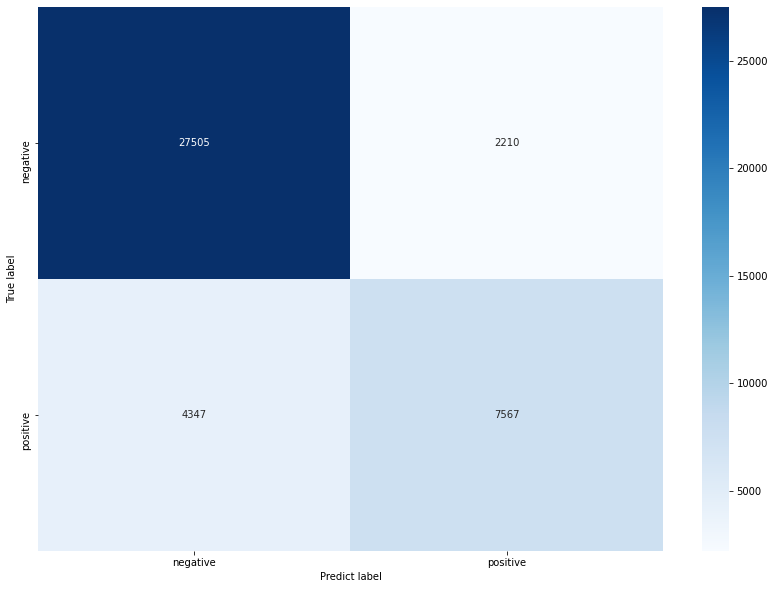

In [40]:
plt.figure(figsize=(14,10))
ax = plt.axes()
sn.heatmap(pd_cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predict label')
ax.set_ylabel('True label')

plt.show()

**F1 score**

In [42]:
fs = f1_score(y_test, predict_label)
print(f'F1 score: {fs:.2f}')

F1 score: 0.70


**Recall score**

In [43]:
rs = recall_score(y_test, predict_label)
print(f'Recall score: {rs:.2f}')

Recall score: 0.64
